In [5]:
!pip install --upgrade sagemaker
!pip install torch==2.1.2
!pip install torchvision==0.16.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 20.7 MB/s eta 0:00:0000:01
  Attempting uninstall: sagemaker
    Found existing installation: sagemaker 2.199.0
    Uninstalling sagemaker-2.199.0:
      Successfully uninstalled sagemaker-2.199.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 71.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 12.1 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 100.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 1.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 6.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 4.2 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 3.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 2.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━

In [3]:
import ast
import boto3
import numpy as np
import os
import sagemaker
import torch
import torchvision
from sagemaker.pytorch.model import PyTorchModel
import cv2
from PIL import Image

from urllib.parse import urlparse
from torchvision.io import read_image
from torchvision.utils import draw_bounding_boxes

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [4]:
sagemaker_session = sagemaker.Session()
default_bucket = sagemaker_session.default_bucket()
aws_region = boto3.Session().region_name
role_arn = sagemaker.get_execution_role()

In [17]:
import torchvision

def get_model(device='cpu', model_name='v2'):
    # Load the model.
    if model_name == 'v2':
        model = torchvision.models.detection.fasterrcnn_resnet50_fpn_v2(
            weights='DEFAULT'
        )
    elif model_name == 'v1':
        model = torchvision.models.detection.fasterrcnn_resnet50_fpn(
            weights='DEFAULT'
        )
    # Load the model onto the computation device.
    model = model.eval().to(device)
    return model

In [59]:
model = get_model()

# torch.save(model.state_dict(), './model_dir/fasterrcnn_resnet50_fpn.pth')
# torch.save(model.state_dict(), 'fasterrcnn_resnet50_fpn.pth')
scripted_model = torch.jit.script(model)
scripted_model.save("model.pth")

In [5]:
coco_names = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

colors = np.random.uniform(0, 255, size=(len(coco_names), 3))

In [6]:
def draw_boxes(boxes, classes, labels, image):
    """
    Draws the bounding box around a detected object.
    """

    lw = 1
    tf = 1
    for i, box in enumerate(boxes):
        color = colors[labels[i]]
        cv2.rectangle(
            img=image,
            pt1=(int(box[0]), int(box[1])),
            pt2=(int(box[2]), int(box[3])),
            color=color, 
            thickness=lw
        )
        cv2.putText(
            img=image, 
            text=classes[i], 
            org=(int(box[0]), int(box[1]-5)),
            fontFace=cv2.FONT_HERSHEY_SIMPLEX, 
            fontScale=lw / 3, 
            color=color, 
            thickness=tf, 
            lineType=cv2.LINE_AA
        )
    return image

In [122]:
!pip install sagemaker-inference

  Preparing metadata (setup.py) ... done
  Created wheel for sagemaker-inference: filename=sagemaker_inference-1.10.1-py2.py3-none-any.whl size=29728 sha256=60de254a7c75b300fcae90d3496a155f4738860a62a9d9757cb23afe845f20cb
  Stored in directory: /home/ec2-user/.cache/pip/wheels/4f/d8/2a/300a5f9c1dbc89f931aff8eaba60a81bd5c9b814c9d4a0f2de
Successfully built sagemaker-inference


In [7]:
torch.__version__

'2.1.2+cu121'

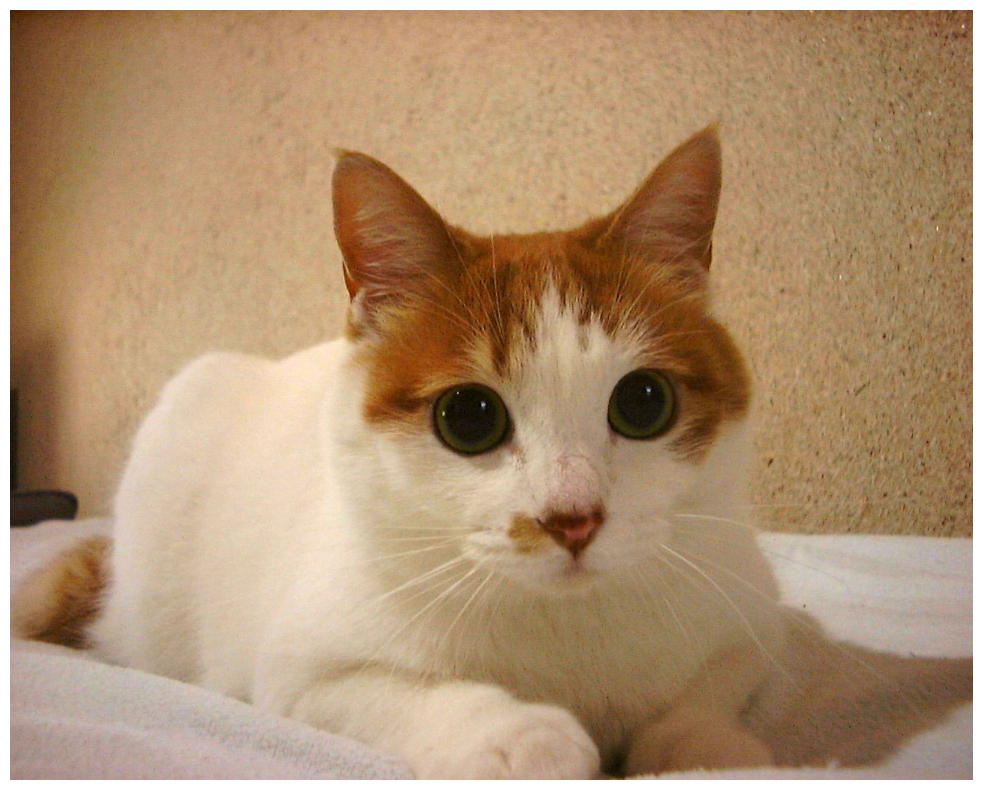

INFO:code.inference:input_fn_start
INFO:code.inference:input_fn_end


Image shape before normalization: (1280, 1024)
Normalized shape: (3, 1024, 1280)


INFO:code.inference:michael - loaded model!!!
INFO:code.inference:predict_fn_start
code/__torch__/torchvision/models/detection/faster_rcnn.py:103: UserWarning: RCNN always returns a (Losses, Detections) tuple in scripting
INFO:code.inference:predict_fn_end
INFO:code.inference:output_fn_start
INFO:code.inference:[0.9943546  0.51540774 0.48536533 0.2991245  0.26002508 0.12879495
 0.10530814 0.10220148 0.06699812]
INFO:code.inference:[[  73  137 1226 1024]]
INFO:code.inference:[17]
INFO:code.inference:['cat']
INFO:code.inference:Constructing JSON
INFO:code.inference:output_fn_end


[0.9943546056747437, 0.5154077410697937, 0.4853653311729431, 0.29912450909614563, 0.2600250840187073, 0.12879495322704315, 0.10530813783407211, 0.10220147669315338, 0.06699812412261963]
[[73, 137, 1226, 1024]]
[17]
['cat']
Normalized shape: (1024, 1280, 3)


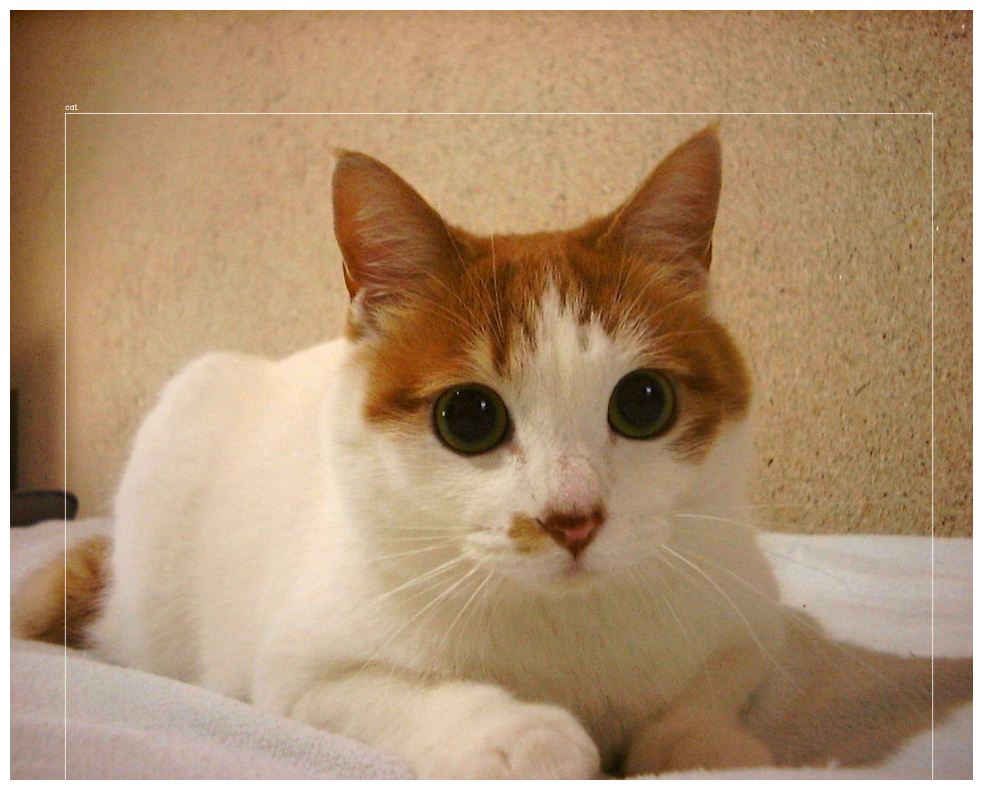

In [8]:
import torch
from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch.nn as nn
import os
import io
import json
from code.inference import model_fn, output_fn, input_fn, predict_fn
from urllib import request
import base64

try:
    image_url = "https://images.freeimages.com/images/large-previews/bd1/cat-1404368.jpg"
    image_data = request.urlopen(image_url).read()
    encoded_image = base64.b64encode(image_data).decode('utf-8')

    image_array = np.asarray(bytearray(image_data), dtype=np.uint8)
    image = Image.open(io.BytesIO(image_array))


    plt.figure(figsize=(15, 10))
    plt.axis('off')
    plt.imshow(image)
    plt.show()
    
    input_tensor = input_fn(encoded_image, 'application/json')

    current_directory = os.getcwd()
    model = model_fn(model_dir=current_directory)
    
    predictions = predict_fn(input_tensor, model)
    formatted_predictions = output_fn(predictions, 'application/json')
    data_json = json.loads(formatted_predictions)
    
    scores = data_json["scores"]
    boxes = data_json["boxes"]
    labels = data_json["labels"]
    classes = data_json["classes"]
    
    print(scores)
    print(boxes)
    print(labels)
    print(classes)    

    reshaped_image_tensor = input_tensor.transpose((1, 2, 0))
    reshaped_image_copy = reshaped_image_tensor.copy()
    print("Normalized shape:", reshaped_image_tensor.shape)
    image_with_boxes = draw_boxes(boxes, classes, labels, reshaped_image_copy)
    image_with_boxes_rgb = cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB)
    

    plt.figure(figsize=(15, 10))
    plt.imshow(image_with_boxes_rgb)
    plt.axis('off')
    plt.savefig("output_image.jpg")
    plt.show()


except Exception as e:
    print(f"An exception occurred: {e}")


In [9]:
# https://sagemaker.readthedocs.io/en/stable/frameworks/pytorch/using_pytorch.html#create-the-directory-structure-for-your-model-files
%cd to_tar
!tar -czvf '../model.tar.gz' .
%cd ..

/home/ec2-user/SageMaker/pytorch-test-michael/to_tar
./
./.ipynb_checkpoints/
./model.pth
./code/
./code/__init__.py
./code/.ipynb_checkpoints/
./code/.ipynb_checkpoints/inference-checkpoint.py
./code/.ipynb_checkpoints/requirements-checkpoint.txt
./code/requirements.txt
./code/inference.py
/home/ec2-user/SageMaker/pytorch-test-michael


In [10]:
!tar -xzvf 'model.tar.gz' -C './output/'

./
./.ipynb_checkpoints/
./model.pth
./code/
./code/__init__.py
./code/.ipynb_checkpoints/
./code/.ipynb_checkpoints/inference-checkpoint.py
./code/.ipynb_checkpoints/requirements-checkpoint.txt
./code/requirements.txt
./code/inference.py


In [11]:
from sagemaker.s3 import S3Uploader

local_model_path = 'model.tar.gz'
default_bucket = sagemaker.Session().default_bucket()
model_data = S3Uploader.upload(local_model_path, f's3://{default_bucket}/michael-models')
print(f'Model artifacts uploaded to: {default_bucket}')

Model artifacts uploaded to: sagemaker-us-west-1-456461478565


In [20]:
!python --version

Python 3.10.13


In [71]:
!pip freeze > requirements.txt

In [12]:
import sagemaker
from sagemaker import get_execution_role
from sagemaker.pytorch import PyTorchModel

framework_version = "1.9.1"
python_version = "py38"

# Create a PyTorchModel instance
pytorch_model = PyTorchModel(
    model_data='s3://sagemaker-us-west-1-456461478565/michael-models/model.tar.gz',
    role=role_arn,
    entry_point='./code/inference.py',
    framework_version=framework_version,
    py_version=python_version,
)

predictor = pytorch_model.deploy(instance_type='ml.t2.medium',
                                 initial_instance_count=1)

--------------------!